Input image 'C:\Users\vanda\Desktop\inputimg\P00053_face3.jpg' is most similar to images in folder 'C:\Users\vanda\Desktop\rootfolder\MID5' with a similarity score of 73.35%


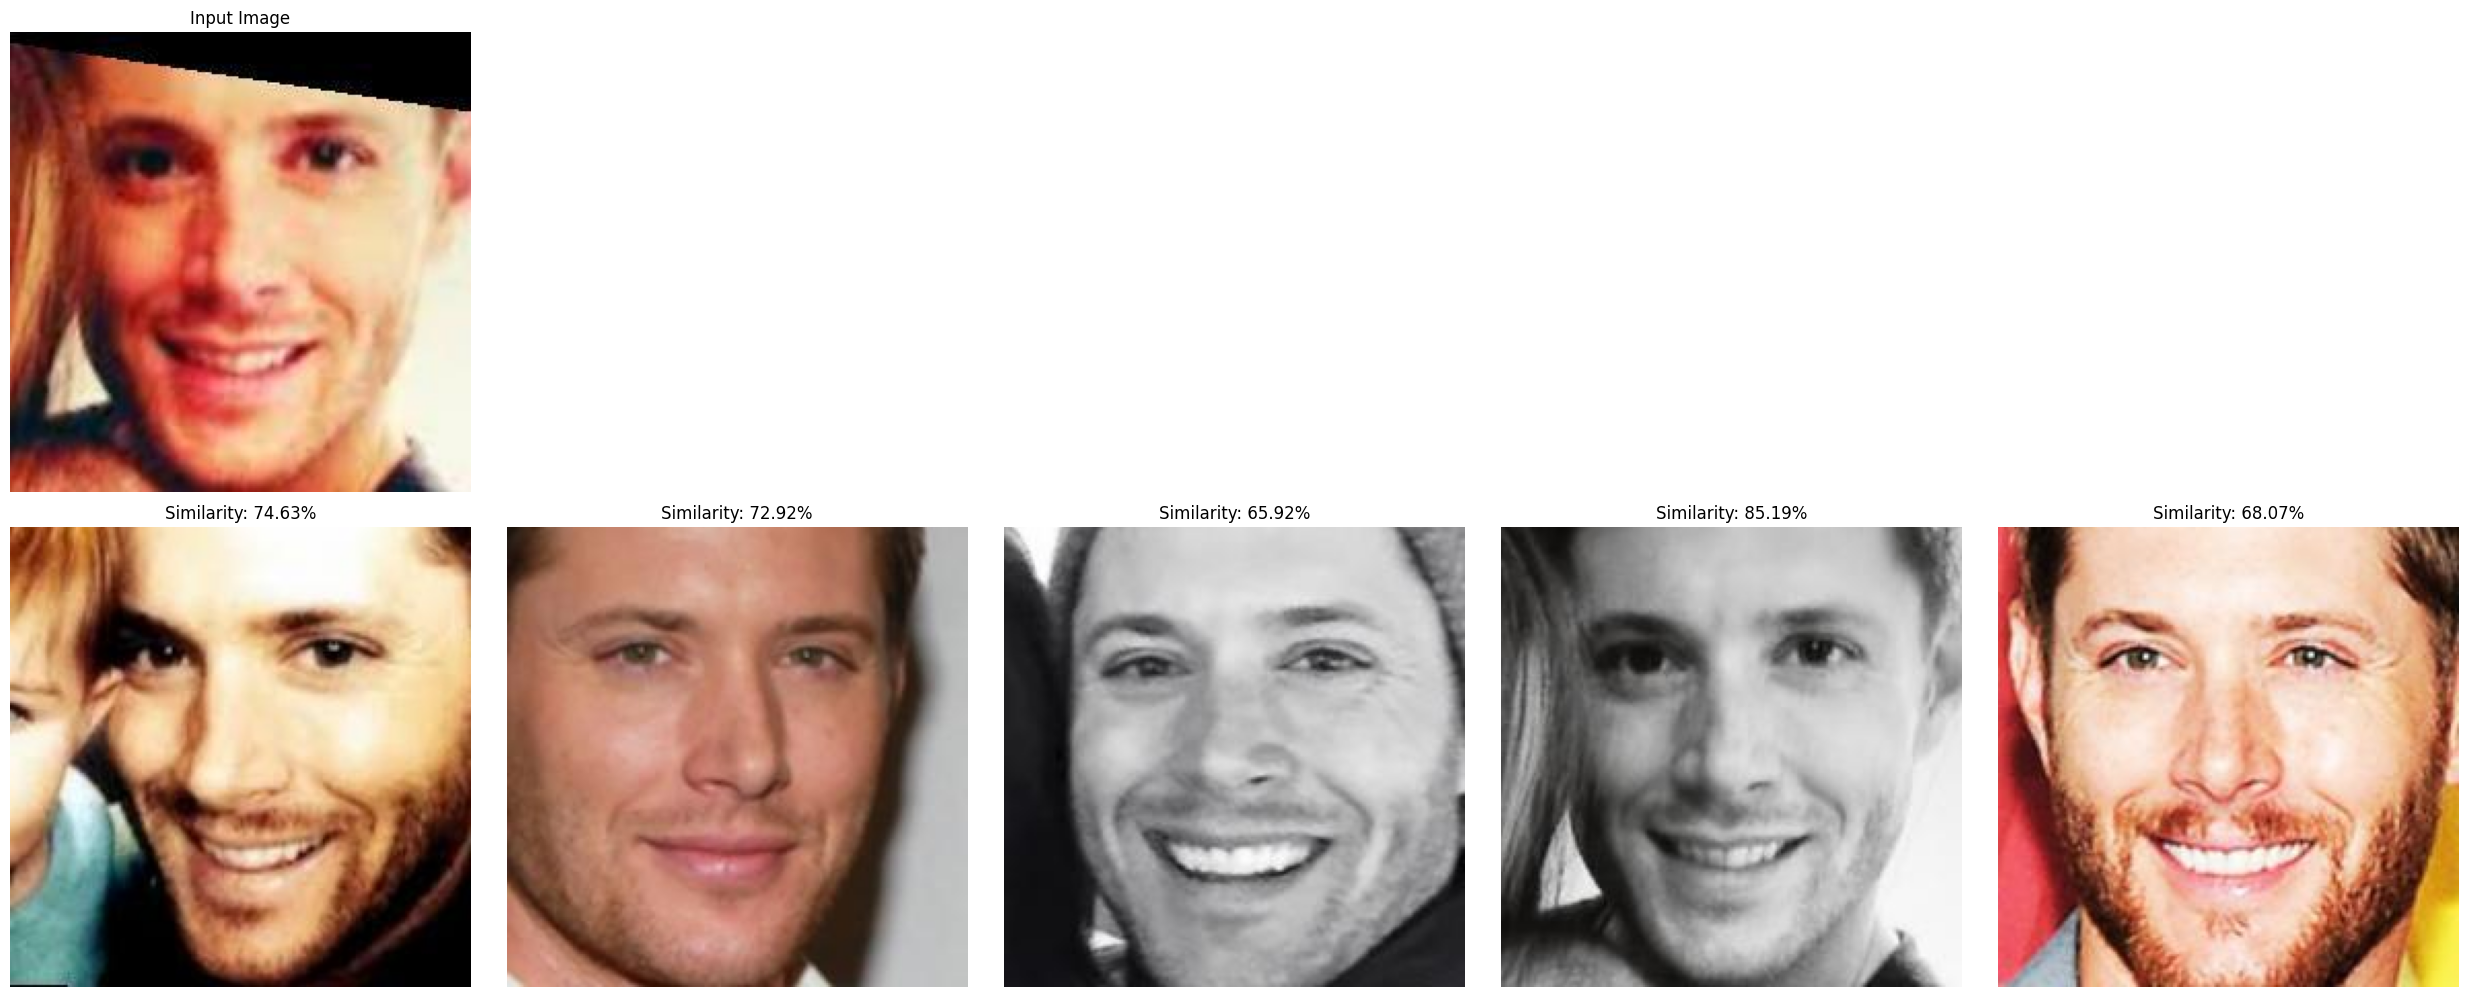

In [3]:
import os
import torch
from PIL import Image
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt

def get_all_image_paths(folder_path):
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return image_paths

def display_result(input_image_path, folder_image_paths, similarity_scores, output_folder):
    input_image = Image.open(input_image_path).convert('RGB')

    num_folder_images = len(folder_image_paths)
    num_cols = min(num_folder_images, 5)  # Display up to 5 images in a row
    num_rows = (num_folder_images // num_cols) + 2  # Rows: one for input image, others for folder images

    plt.figure(figsize=(5 * num_cols, 5 * num_rows))

    # Display input image
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis('off')

    # Display folder images with similarity scores
    for i, (image_path, similarity_score) in enumerate(zip(folder_image_paths, similarity_scores), start=1):
        image = Image.open(image_path).convert('RGB')
        plt.subplot(num_rows, num_cols, num_cols + i)
        plt.imshow(image)
        plt.title(f"Similarity: {similarity_score*100:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    
    # Save the plot as an image
    output_image_path = os.path.join(output_folder, f"output_{os.path.basename(input_image_path)}.png")
    plt.savefig(output_image_path)
    plt.show()

def save_output_to_text(output_file, input_image_path, highest_similarity_folder, highest_similarity, folder_image_paths, similarity_scores):
    with open(output_file, 'a') as file:
        file.write(f"Input image: {input_image_path}\n")
        file.write(f"Most similar folder: {highest_similarity_folder}\n")
        file.write(f"Similarity score: {highest_similarity*100:.2f}%\n")
        
        for image_path, score in zip(folder_image_paths, similarity_scores):
            file.write(f"Folder image: {image_path}, Similarity score: {score*100:.2f}%\n")
        
        file.write("\n")

def get_facial_features(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    image = Image.open(image_path).convert('RGB')
    boxes, _ = mtcnn.detect(image)
    if boxes is None or len(boxes) == 0:
        print(f"No face found in the image: {image_path}")
        return None

    aligned = mtcnn(image)
    features = resnet(aligned).detach().cpu().numpy()

    return features[0]

def calculate_similarity(features1, features2):
    if features1 is None or features2 is None:
        return 0.0  # Default similarity score when features are not available
    similarity_score = np.dot(features1, features2) / (np.linalg.norm(features1) * np.linalg.norm(features2))
    return similarity_score

def get_highest_similarity_folder(input_image_path, root_folder_path):
    # Get facial features from the input image
    facial_features_input = get_facial_features(input_image_path)

    if facial_features_input is None:
        print("No face found in the input image. Stopping execution.")
        return None, 0.0

    # Initialize variables to store the highest similarity and corresponding folder
    highest_similarity = -1.0
    highest_similarity_folder = None

    # Get all subfolders in the root folder
    subfolders = [f.path for f in os.scandir(root_folder_path) if f.is_dir()]

    # Calculate similarity scores for each subfolder
    for folder_path in subfolders:
        # Get all image paths in the subfolder
        folder_image_paths = get_all_image_paths(folder_path)

        # Calculate similarity scores for each folder image
        similarity_scores = []
        for image_path in folder_image_paths:
            facial_features_folder = get_facial_features(image_path)
            similarity_score = calculate_similarity(facial_features_input, facial_features_folder)
            similarity_scores.append(similarity_score)

        # Calculate the average similarity for the subfolder
        average_similarity = np.mean(similarity_scores)

        # Update the highest similarity and corresponding folder if needed
        if average_similarity > highest_similarity:
            highest_similarity = average_similarity
            highest_similarity_folder = folder_path

    return highest_similarity_folder, highest_similarity

if __name__ == "__main__":
    # List of input image paths
    input_image_paths = [
     # r"C:\Users\vanda\Desktop\chimpanzee.jpeg"
        r"C:\Users\vanda\Desktop\inputimg\P00053_face3.jpg"
        
        # Add more input image paths as needed
    ]

    root_folder_path = r"C:\Users\vanda\Desktop\rootfolder"
    output_folder = r"C:\Users\vanda\Desktop\result"
    output_file = os.path.join(output_folder, "output.txt")

    # Create output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for input_image_path in input_image_paths:
        highest_similarity_folder, highest_similarity = get_highest_similarity_folder(input_image_path, root_folder_path)

        if highest_similarity_folder is not None:
            print(f"Input image '{input_image_path}' is most similar to images in folder '{highest_similarity_folder}' with a similarity score of {highest_similarity*100:.2f}%")
            
            # Display results for the current input image
            folder_image_paths = get_all_image_paths(highest_similarity_folder)
            similarity_scores = [calculate_similarity(get_facial_features(input_image_path), get_facial_features(image_path)) for image_path in folder_image_paths]
            
            display_result(input_image_path, folder_image_paths, similarity_scores, output_folder)
            
            # Save the output to a text file
            save_output_to_text(output_file, input_image_path, highest_similarity_folder, highest_similarity, folder_image_paths, similarity_scores)
            
        else:
            print(f"Error calculating similarity for input image '{input_image_path}'.")


In [5]:
import os
import torch
from PIL import Image
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ... (Rest of your code)
def get_all_image_paths(folder_path):
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return image_paths

def display_result(input_image_path, folder_image_paths, similarity_scores, output_folder):
    input_image = Image.open(input_image_path).convert('RGB')

    num_folder_images = len(folder_image_paths)
    num_cols = min(num_folder_images, 5)  # Display up to 5 images in a row
    num_rows = (num_folder_images // num_cols) + 2  # Rows: one for input image, others for folder images

    plt.figure(figsize=(5 * num_cols, 5 * num_rows))

    # Display input image
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(input_image)
    plt.title("Input Image")
    plt.axis('off')

    # Display folder images with similarity scores
    for i, (image_path, similarity_score) in enumerate(zip(folder_image_paths, similarity_scores), start=1):
        image = Image.open(image_path).convert('RGB')
        plt.subplot(num_rows, num_cols, num_cols + i)
        plt.imshow(image)
        plt.title(f"Similarity: {similarity_score*100:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    
    # Save the plot as an image
    output_image_path = os.path.join(output_folder, f"output_{os.path.basename(input_image_path)}.png")
    plt.savefig(output_image_path)
    plt.show()

def save_output_to_text(output_file, input_image_path, highest_similarity_folder, highest_similarity, folder_image_paths, similarity_scores):
    with open(output_file, 'a') as file:
        file.write(f"Input image: {input_image_path}\n")
        file.write(f"Most similar folder: {highest_similarity_folder}\n")
        file.write(f"Similarity score: {highest_similarity*100:.2f}%\n")
        
        for image_path, score in zip(folder_image_paths, similarity_scores):
            file.write(f"Folder image: {image_path}, Similarity score: {score*100:.2f}%\n")
        
        file.write("\n")

def get_facial_features(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    image = Image.open(image_path).convert('RGB')
    boxes, _ = mtcnn.detect(image)
    if boxes is None or len(boxes) == 0:
        print(f"No face found in the image: {image_path}")
        return None

    aligned = mtcnn(image)
    features = resnet(aligned).detach().cpu().numpy()

    return features[0]


def calculate_similarity(features1, features2):
    if features1 is None or features2 is None:
        return 0.0  # Default similarity score when features are not available
    similarity_score = np.dot(features1, features2) / (np.linalg.norm(features1) * np.linalg.norm(features2))
    return similarity_score

def get_ground_truth_labels(input_folder, root_folder_path):
    labels = []
    for subfolder in os.listdir(root_folder_path):
        subfolder_path = os.path.join(root_folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for image_path in os.listdir(subfolder_path):
                image_full_path = os.path.join(subfolder_path, image_path)
                labels.append(int(subfolder == os.path.basename(input_folder)))
    return labels



if __name__ == "__main__":
    # List of input image paths
    input_image_paths = [
        r"C:\Users\vanda\Desktop\inputimg\P00053_face3.jpg"
        # Add more input image paths as needed
    ]

    root_folder_path = r"C:\Users\vanda\Desktop\rootfolder"

    generate_roc_curve(input_image_paths, root_folder_path)


AttributeError: 'list' object has no attribute 'read'